# Stock Market Prediction And Forecasting Using Stacked LSTM 

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, LSTM # type: ignore
import yfinance as yf

# Ensure matplotlib plots display inline
%matplotlib inline

### Download Data from yahoo finance

In [2]:
# Download data for HDFC from Yahoo Finance
ticker = 'HDFCBANK.NS' 
df = yf.download(ticker, start='2020-01-01', end='2023-12-31')

df.to_csv('hdfc_stock_data.csv')

df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,1276.099976,1280.000000,1270.599976,1278.599976,1227.428589,1836849
2020-01-02,1279.000000,1288.000000,1279.000000,1286.750000,1235.252441,3068583
2020-01-03,1282.199951,1285.000000,1263.599976,1268.400024,1217.636963,5427775
2020-01-06,1260.000000,1261.800049,1236.000000,1240.949951,1191.285522,5445093
2020-01-07,1258.900024,1271.449951,1252.250000,1260.599976,1210.149048,7362247


### Display the last few rows

In [3]:
# Display the last few rows of the dataframe
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,1683.599976,1685.900024,1667.099976,1670.849976,1648.341187,24289425
2023-12-26,1673.250000,1685.949951,1668.550049,1682.449951,1659.784912,9022928
2023-12-27,1681.500000,1706.500000,1678.599976,1703.300049,1680.354126,13504539
2023-12-28,1709.300049,1721.400024,1702.000000,1705.250000,1682.277710,22038235
2023-12-29,1697.000000,1714.900024,1696.000000,1709.250000,1686.223877,12505713


### Reset Index and Extract 'Close' Prices

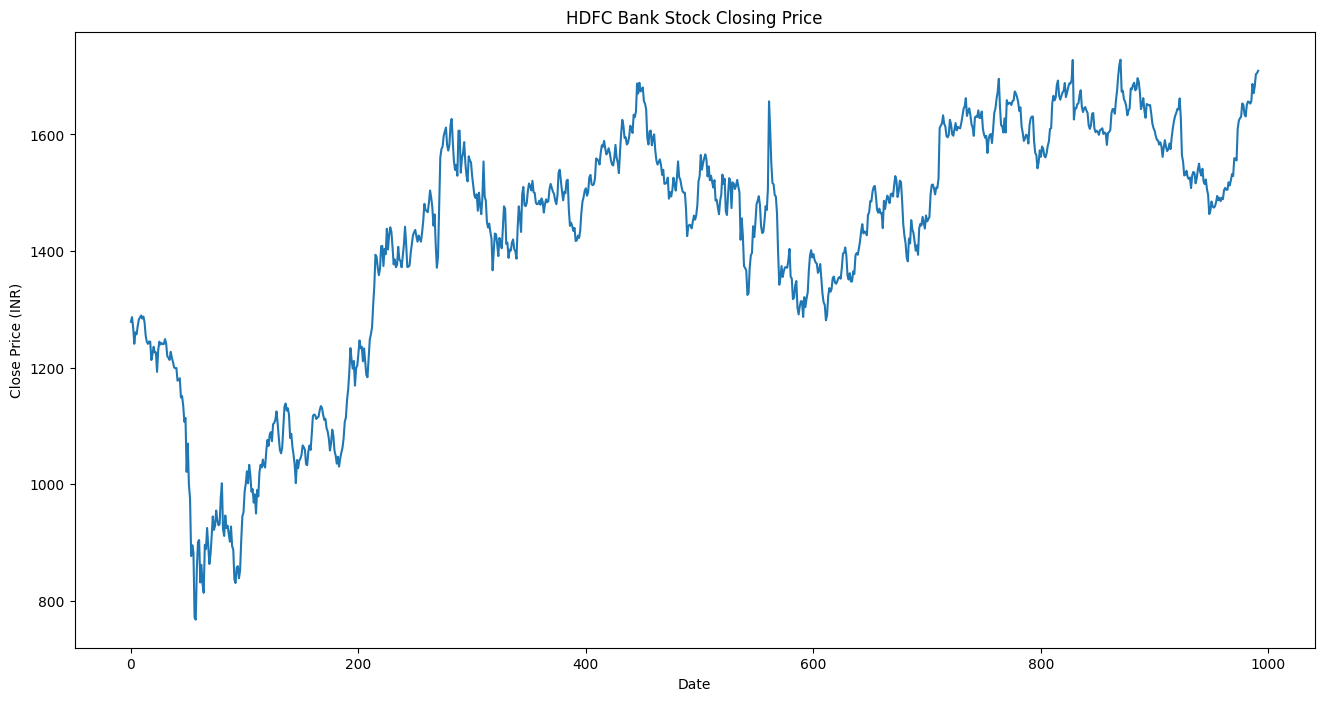

In [4]:
df1 = df.reset_index()['Close']

# Plotting the 'Close' prices
plt.figure(figsize=(16,8))
plt.plot(df1)
plt.title('HDFC Bank Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.show()

### Preprocess data

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

training_size = int(len(df1) * 0.65)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size, :], df1[training_size:len(df1), :1]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Create training and testing datasets
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Build the LSTM model

In [7]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.0204
Epoch 2/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0033
Epoch 3/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0027
Epoch 4/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0019
Epoch 5/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0013
Epoch 6/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0014
Epoch 7/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0014
Epoch 8/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0013
Epoch 9/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 9.9466e-04
Epoch 10/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0011


### Make predictions and evaluate the model

In [8]:
# Make predictions using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate Root Mean Squared Error (RMSE)
import math
from sklearn.metrics import mean_squared_error

train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Train RMSE: 1368.4565398348702
Test RMSE: 1567.0464446517906


### Plot Predictions

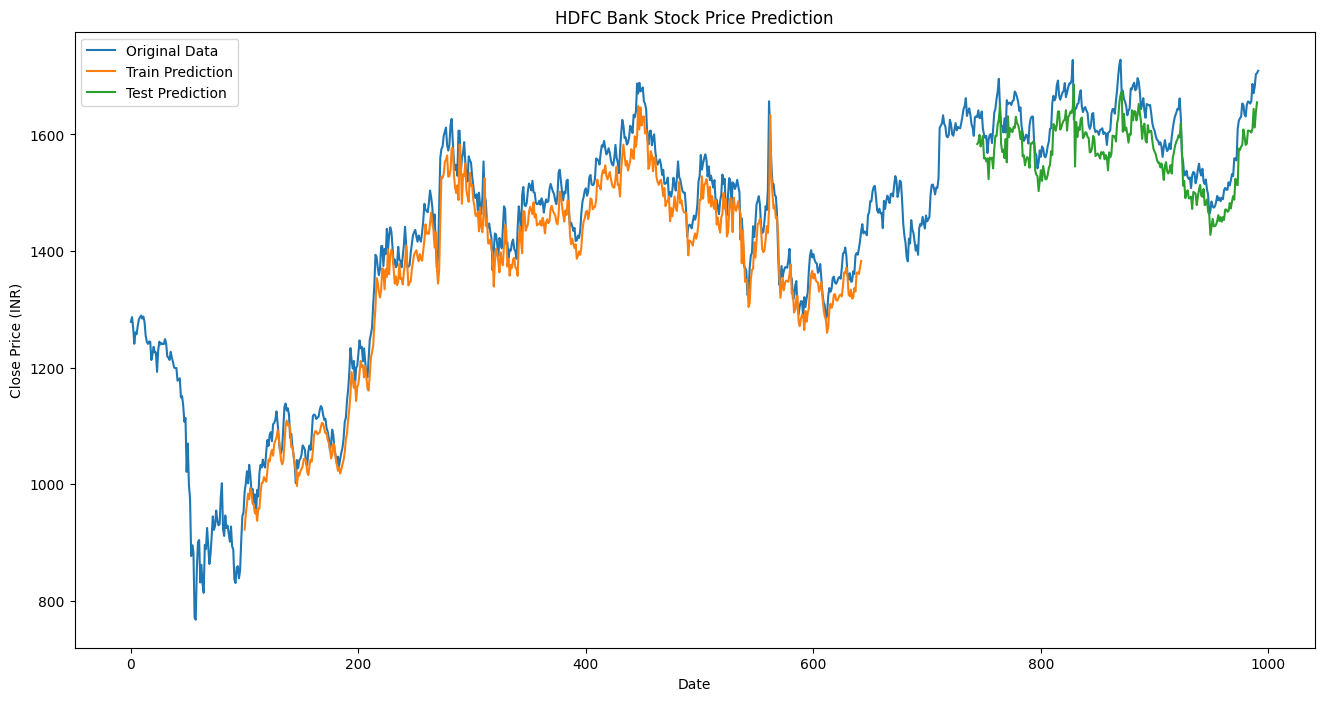

In [9]:
# Plotting the predictions
look_back = 100
train_predict_plot = np.empty_like(df1)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(df1) - 1, :] = test_predict

plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(df1))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.title('HDFC Bank Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.legend(['Original Data', 'Train Prediction', 'Test Prediction'], loc='upper left')
plt.show()

### Make future predictions

In [10]:
# Prepare data for future predictions
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the next 10 days
from numpy import array

lst_output = []
n_steps = time_step
i = 0
while(i < 10):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print("Future predictions:", scaler.inverse_transform(lst_output))

Future predictions: [[1657.99888371]
 [1593.52776555]
 [1542.30807827]
 [1501.92162825]
 [1468.56058635]
 [1440.13840968]
 [1415.56963335]
 [1394.16845653]
 [1375.37880746]
 [1358.69104436]]


### Plot future predictions

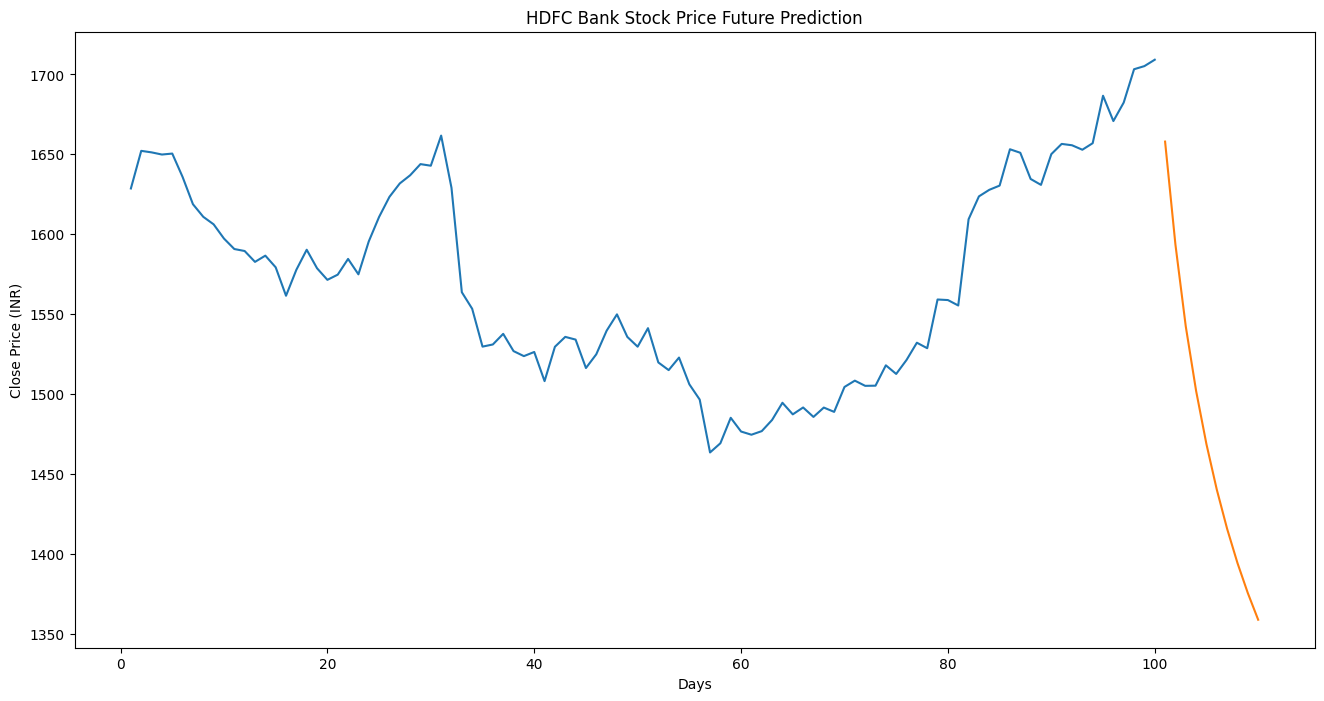

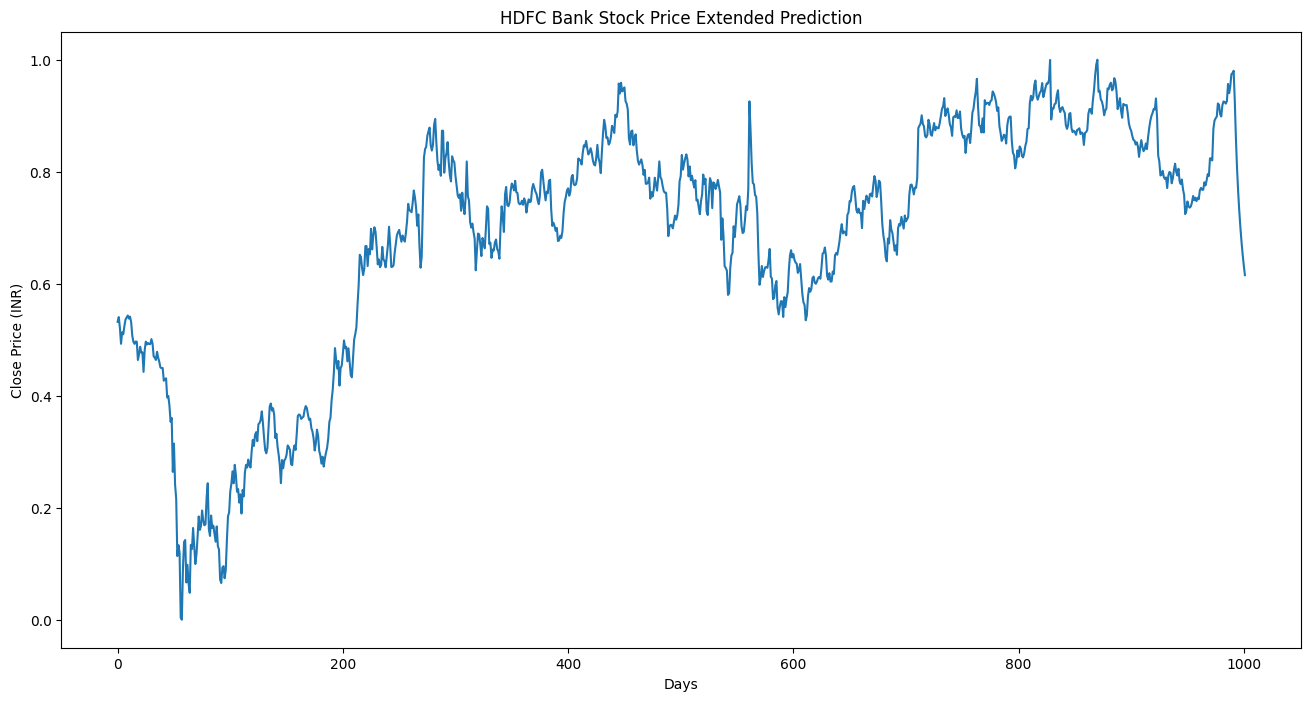

In [11]:
# Plot the future predictions
day_new = np.arange(1, 101)
day_pred = np.arange(101, 111)

plt.figure(figsize=(16,8))
plt.plot(day_new, scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))
plt.title('HDFC Bank Stock Price Future Prediction')
plt.xlabel('Days')
plt.ylabel('Close Price (INR)')
plt.show()

df2 = df1.tolist()
df2.extend(lst_output)
plt.figure(figsize=(16,8))
plt.plot(df2)
plt.title('HDFC Bank Stock Price Extended Prediction')
plt.xlabel('Days')
plt.ylabel('Close Price (INR)')
plt.show()

This concludes how LSTM(Long Short-term Memory), a recurrent neural network model good at detecting patterns, is used to predict stock market prices, with remarkable accuracy

### ----End----